# Step 0. 라이브러리 불러들이기

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.6.0
19.24.0


# Step 1. 스티커 구하기, 그리고 내 사진 불러오기

Mounted at /content/drive


<function matplotlib.pyplot.show>

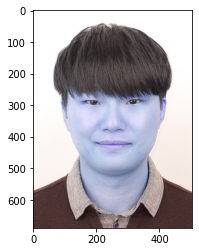

In [ ]:
# 내 사진 불러오기
from google.colab import drive
drive.mount('/content/drive')

my_image_path = '/content/drive/MyDrive/AIFFEL/geonhee3.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show

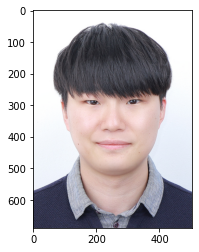

In [ ]:
# 사람 피부가 파란색으로 나왔으니, bgr을 rgb로 바꿔서 보정 처리
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Step 2. 얼굴 검출&랜드마크 검출하기

rectangles[[(98, 206) (419, 527)]]


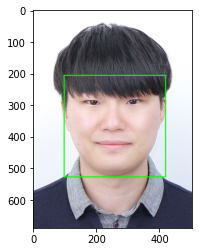

In [ ]:
# detector를 선언한다.
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있다.
print(dlib_rects)  

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# 얼굴 랜드마크 데이터 다운로드. 총 68개의 인덱스를 보유함.
model_path = '/content/drive/MyDrive/AIFFEL/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


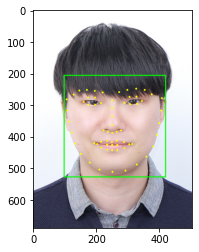

In [ ]:
# point 뒤에 3이라는 숫자는 포인트의 크기를 나타낸다.
# 크기를 2로 해도 되는데, 좀 작은 거 같아서 3으로 설정했다.
for landmark in list_landmarks:
  for point in landmark:
      cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 위치를 landmark를 사용해서 계산. 30번 인덱스에 위치시켜 보자!!

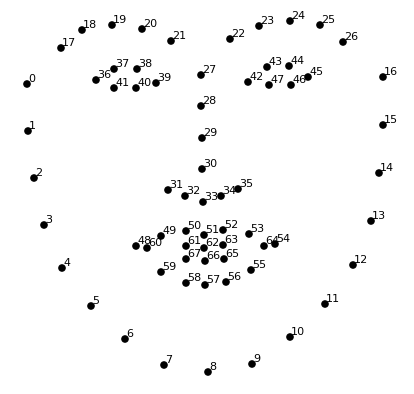

In [ ]:
# 좌표를 먼저 확인한다!!!
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    # 위의 68개 이목구비를 인덱스로 나타낸 이미지를 참고하자!!!
    # 코끝인 30번 위치에 인덱스 시키는 부분
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(250, 363)
(x,y) : (250, 202)
(w,h) : (322, 322)


In [ ]:
# 준비해 둔 스티커 이미지를 읽어서 적용.
sticker_path = '/content/drive/MyDrive/AIFFEL/cat-whiskers2.png'

# 스티커 이미지 불러들이기 및 윗 단계에서 계산한 크기대로 resize
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

(322, 322, 3)


In [ ]:
# 스티커의 위치를 직접적으로 바꿔주는 부분.
# 스티커가 원하는 부분에 안 붙여져 있다면 이 부분을 수정해야 된다.
# 스티커가 붙어야 하는 x좌표와 y좌표를 계산 및 수정작업을 반복함으로써 최상의 위치를 찾아낸다.
refined_x = x - w // 2 + 5
refined_y = h - y + 90
print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(x,y) : (94, 210)


In [ ]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[- refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (94,210)


# Step 4. 스티커 적용하기

이제 스티커를 부착하는 과정에 이르렀다. 스티커를 붙인다는 것은 엄밀히 말하면 내 모습이 보이는 이미지와 고양이 수염 스티커 이미지를 합성한다는 것을 의미한다.  
그러나 이 때 그냥 합성을 하게 되면 자칫 고양이 수염 스티커 이미지의 바탕색이 잔상이 남아서 이상하게 보이는 경우가 있다. 이 때 활용하는 함수가 cv2.addWeighted이다. 이 함수는 가중치 합, 평균 연산으로써 덧셈 연산을 할 시에 많은 부분이 흰색으로 나오는데, 두 이미지의 같은 위치에 존재하는 픽셀 값에 대하여 가중합을 계산하여 결과 영상의 픽셀 값으로 설정하는 기능을 한다.  
즉, 각각의 영상에 가중치를 곱하여 더해주면 두 입력 영상의 평균 밝기를 유지할 수 있다. 이미지, 영상의 산술 영상 관련 링크를 남기니 참고 바란다.  

https://deep-learning-study.tistory.com/115

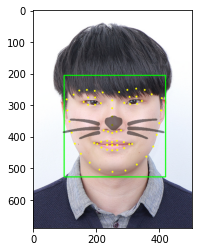

In [ ]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
# 원본 이미지에 스티커를 적용하는 부분
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

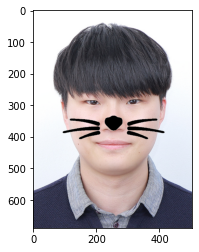

In [ ]:
# 원래는 cv2.addWeighted를 써야 하는데, 어느 순간부터 이 함수를 쓰지 않아도 고양이 수염이 선명하게 나오게 되었다.
sticker_area=img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Step 5. 다른 각도에서 촬영한 사진에의 적용

<function matplotlib.pyplot.show>

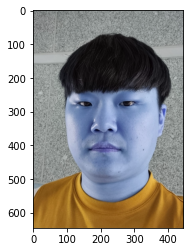

In [ ]:
# 이번에는 다른 각도로 촬영한 셀카 사진을 들고 왔다.
my_image_path = '/content/drive/MyDrive/AIFFEL/geonhee4.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show

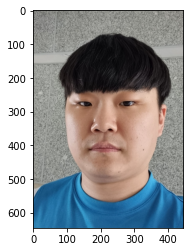

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(98, 206) (419, 527)]]


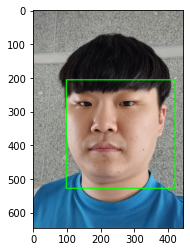

In [ ]:
print(dlib_rects)  

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

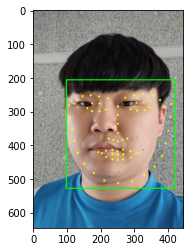

In [ ]:
# 정면 사진과 다르게 좀 틀어서 찍은 셀카의 경우 얼굴 랜드마크가 다소 이상하게 찍힌 거 같은 느낌적인 느낌!!!
for landmark in list_landmarks:
  for point in landmark:
      cv2.circle(img_show, point, 3, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# 좌표를 먼저 확인한다!!!
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    
    # 위의 68개 이목구비를 인덱스로 나타낸 이미지를 참고하자!!!
    print(landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(250, 388)
(x,y) : (250, 227)
(w,h) : (322, 322)


In [ ]:
# 준비해 둔 스티커 이미지를 읽어서 적용.
sticker_path = '/content/drive/MyDrive/AIFFEL/cat-whiskers.png'

# 스티커 이미지 불러들이기 및 윗 단계에서 계산한 크기대로 resize
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

(322, 322, 3)


In [ ]:
refined_x = x - w // 2 - 30
refined_y = h - y + 90
print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(x,y) : (59, 185)


In [ ]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[- refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (59,185)


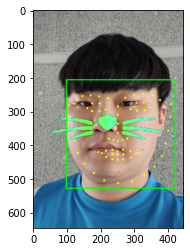

In [ ]:
# 고양이 수염이 녹색인 것은 안 비밀!!!
# 사실 고양이 수염 다운받기 전에 색깔 설정하는 부분이 있었는데 거기에서 설정 후 다운로드를 했더니 짜잔하고 녹색 수염이!!!!!
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

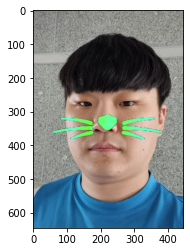

In [ ]:
sticker_area=img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

1. 이론상으로는 이해하는 데 큰 무리가 없었지만, 실전 프로젝트로 부딪혀 보니 상당히 많은 계산과 이해도가 필요했던 내용이라는 생각이 들었다.  

2. 특히 수염 이미지를 붙였을 때 수염 이미지의 바탕색 잔상이 남았던 부분과 스티커의 이미지를 조정하는 부분이 가장 기억에 남았다. 왜냐하면 처음에는 잔상이 흰색으로 보이기도 했고, 검은색으로 보이기도 했으며 수염의 위치 역시 처음 할 때는 코에 붙어 있어야 하는데 머리랑 눈 쪽에 붙어서 원하는 위치를 맞추기 위해 계속 조정을 했기 때문이다.  

3. 약간 각도를 틀어 촬영한 이미지에 대해서는 랜드마크가 이상하게 찍힌 점이 마음에 걸렸다. 또한 스티커 위치 역시 정면 사진 때와 동일한 위치에 그대로 부착하면 역시나 이상한 위치에 스티커가 부착되어 있는 결과를 얻을 수 있었다. 랜드마크의 이해도 필요하지만 스티커가 붙어야 할 최상의 위치를 찾기 위한 공부가 더 필요해 보인다.  

4. 마지막으로, 고양이 수염 이미지 다운 전에 수염의 색깔을 설정하여 다운로드를 진행하여 그 스티커를 부착하는 것과, 셀프 카메라 촬영한 사진을 활용 등 다양한 시도를 해서 CV에 대한 이해가 더 잘 되었던 거 같다.
